In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

plt.rcParams['xtick.major.size'] = 18
plt.rcParams['ytick.major.size'] = 18
plt.rc('legend', fontsize=20)
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
def parse_nvidia_smi_output(path, start=None, stop=None):
    df = pd.read_csv(path)
    df = df[df["index"] == 0]
    df = df.reset_index(drop=True)
    f, ax = plt.subplots(1,1, figsize=(10,10))

    if start is not None:
        df = df.iloc[start:]
    if stop is not None:
        df = df.iloc[:stop]

    df[' power.draw [W]'] =df[' power.draw [W]'].apply(lambda x: float(x.split(" ")[1])) 
    sns.lineplot(x=list(range(len(df))), y=df[' power.draw [W]'], ax=ax)
    print(df[' power.draw [W]'].mean())

In [3]:
# parse_nvidia_smi_output("/g/g13/jones289/workspace/hd-cuda-master/hdpy/molformer_nvidia-smi_output_1k.csv")
# test_path = "/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdbind-rp-molformer-1k_nvidia-smi_test.csv"
# parse_nvidia_smi_output(test_path)

In [4]:
# parse_nvidia_smi_output(test_path,
                        # start=0, stop=110)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


Index(['Socket_0 Power (W)', 'Mem_0 Power (W)', 'GPU_0 Power (W)',
       'GPU_1 Power (W)', 'Socket_1 Power (W)', 'Mem_1 Power (W)',
       'GPU_2 Power (W)', 'GPU_3 Power (W)'],
      dtype='object')


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


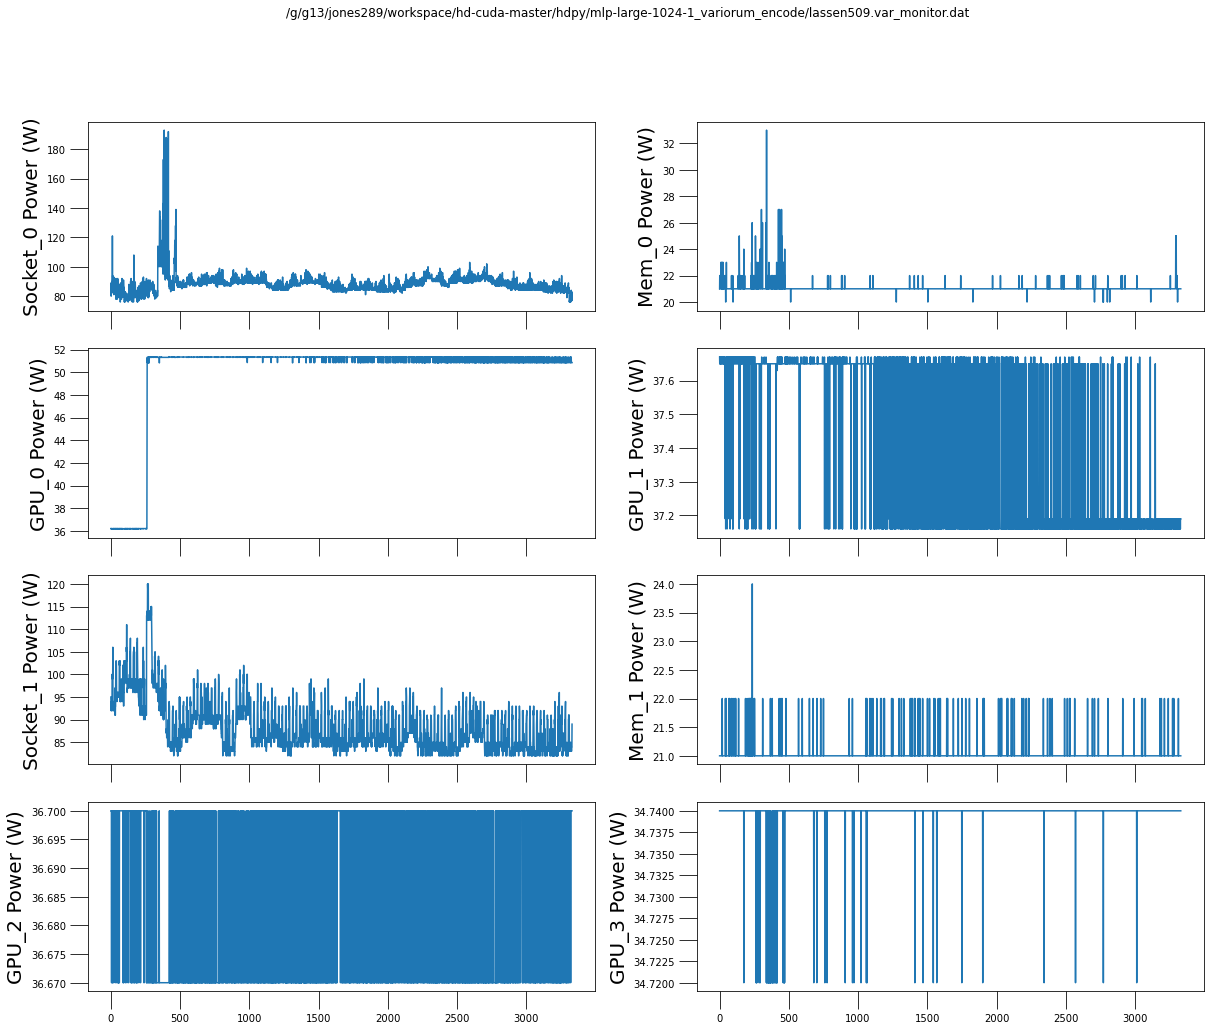

In [5]:
def plot_variorum(path):
    f, ax = plt.subplots(4,2, figsize=(20,16), sharex=True)
    ax = ax.flatten()
    df = pd.read_csv(path)
    cols = df.columns[3:]
    print(cols)

    for idx, col in enumerate(cols):
        
        ax[idx].plot(df[col].values)
        ax[idx].set_ylabel(col)

    f.suptitle(path)


plot_variorum("/g/g13/jones289/workspace/hd-cuda-master/hdpy/mlp-large-1024-1_variorum_encode/lassen509.var_monitor.dat")

In [6]:
TIME_PER_SAMPLE=.05 # this corresponds to milliseconds, sampling interval for variorum
# N=41127

def convert_var_monitor_path_to_timing_path(path):
    mode = path.parent.name.split("_")[-1]
    model = path.parent.name.split("_")[0]
    timing_path = path.parent.parent / Path(f"{model}_timing_{mode}.npy") 
    return timing_path

def parse_var_monitor_output(path):
    try:
        path = Path(path)

        mode = path.parent.name.split("_")[-1]
        model = path.parent.name.split("_")[0]
        # timing_path = path.parent.parent / Path(f"{model}_timing_{mode}.npy")
        timing_path = convert_var_monitor_path_to_timing_path(path)
        timing_data = np.load(timing_path)
        N, mean_time_crit, std_time_crit = timing_data


        df = pd.read_csv(path)

        gpu_power = 0
        if df[df['GPU_0 Power (W)'] > 37]['GPU_0 Power (W)'].shape[0] == 0:

            gpu_power = df['GPU_0 Power (W)'].values.mean()
        else:
            gpu_power = df[df['GPU_0 Power (W)'] > 37]['GPU_0 Power (W)'].values.mean() # 37 watts is a threshold for detecing where GPU is idle
        
        
        cpu_power = df[['Socket_0 Power (W)', 'Socket_1 Power (W)']].mean().sum()
        
        total_time = TIME_PER_SAMPLE * df.shape[0]
        mean_time = total_time / N


        cpu_energy = cpu_power * (mean_time - mean_time_crit)
        # crit_energy = (cpu_power + gpu_power) * mean_time_crit
        crit_energy = (gpu_power) * mean_time_crit


        result_dict = {
                        "path": path, "model": model, "mode": mode,
                        "cpu_power": cpu_power, "gpu_power": gpu_power,
                        "mean_time_crit": mean_time_crit, "std_time_crit": std_time_crit, 
                        # "total_time": total_time, "mean_time": total_time/N,
                        "mean_time_cpu": mean_time - mean_time_crit,
                        "cpu_energy": cpu_energy,
                        "crit_energy": crit_energy
                       }
        
        return pd.DataFrame(result_dict, index=[0])

    except Exception as e:
        print(e)
        return

def collect_energy_metrics(path_list):
    result_list = []
    for p in path_list:
        result_list.append(parse_var_monitor_output(p))
        # plot_variorum(p)

    df = pd.concat([x for x in result_list if x is not None])
    df = df.reset_index(drop=True)
    return df

In [7]:
# result_dir = "profile_1718776537"
# result_dir = "profile_1718914056"
# result_dir = "profile_1718916517"
# result_dir="profile_1718928038"
# result_dir = "profile_1718929161"
result_dir = "profile_1719448447"
encode_path_list = list(Path(f"/g/g13/jones289/workspace/hd-cuda-master/hdpy/{result_dir}").glob("*_variorum_encode/*.dat"))
test_path_list = list(Path(f"/g/g13/jones289/workspace/hd-cuda-master/hdpy/{result_dir}").glob("*_variorum_test/*.dat"))

encode_df = collect_energy_metrics(encode_path_list)
test_df = collect_energy_metrics(test_path_list)

energy_df = pd.concat([encode_df, test_df])
energy_df

,path,model,mode,cpu_power,gpu_power,mean_time_crit,std_time_crit,mean_time_cpu,cpu_energy,crit_energy
0,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-directecfp-1k-1,encode,165.543210,35.299565,0.000364,2.171393e-07,0.004450,0.736748,0.012846
1,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-molformer-decfp-combo-1k,encode,172.658679,50.886729,0.000232,1.128271e-05,0.011550,1.994178,0.011816
2,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-rp-molformer-1k,encode,169.936922,53.959535,0.000167,3.805672e-05,0.005380,0.914199,0.009007
3,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-large-1024-1,encode,160.597115,35.260013,0.000364,1.150456e-07,0.004692,0.753592,0.012826
4,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-small-1024-1,encode,175.833605,36.323138,0.000364,1.162476e-07,0.004604,0.809587,0.013226
0,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-directecfp-1k-1,test,160.754703,51.470409,0.000288,1.135226e-05,0.016371,2.631693,0.014808
1,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-molformer-decfp-combo-1k,test,154.052771,52.326866,0.000282,1.192230e-05,0.011468,1.766635,0.014750
2,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-rp-molformer-1k,test,156.184420,52.434563,0.000277,1.186106e-05,0.011289,1.763114,0.014536
3,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-large-1024-1,test,193.783751,54.334872,0.000355,2.208468e-07,0.008491,1.645347,0.019271
4,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-small-1024-1,test,168.077048,53.225150,0.000219,2.136049e-07,0.007285,1.224479,0.011640


In [8]:
openhd_result_dir = "profile_openhd_1719444606" 
openhd_test_path_list = list(Path(f"/g/g13/jones289/workspace/hd-cuda-master/hdpy/{openhd_result_dir}").glob("hdbind-openhd_test/*.dat"))
print(openhd_test_path_list)
print(convert_var_monitor_path_to_timing_path(openhd_test_path_list[0]))

openhd_test_df = collect_energy_metrics(openhd_test_path_list)
openhd_test_df

[PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/profile_openhd_1719444606/hdbind-openhd_test/lassen77.var_monitor.dat')]
/g/g13/jones289/workspace/hd-cuda-master/hdpy/profile_openhd_1719444606/hdbind-openhd_timing_test.npy


,path,model,mode,cpu_power,gpu_power,mean_time_crit,std_time_crit,mean_time_cpu,cpu_energy,crit_energy
0,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-openhd,test,197.823529,52.405593,3.157458e-08,8.988719e-10,0.000092,0.018165,0.000002


In [9]:
full_energy_df = pd.concat([energy_df, openhd_test_df], axis=0)
full_energy_df

,path,model,mode,cpu_power,gpu_power,mean_time_crit,std_time_crit,mean_time_cpu,cpu_energy,crit_energy
0,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-directecfp-1k-1,encode,165.543210,35.299565,3.639079e-04,2.171393e-07,0.004450,0.736748,0.012846
1,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-molformer-decfp-combo-1k,encode,172.658679,50.886729,2.322018e-04,1.128271e-05,0.011550,1.994178,0.011816
2,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-rp-molformer-1k,encode,169.936922,53.959535,1.669132e-04,3.805672e-05,0.005380,0.914199,0.009007
3,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-large-1024-1,encode,160.597115,35.260013,3.637556e-04,1.150456e-07,0.004692,0.753592,0.012826
4,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-small-1024-1,encode,175.833605,36.323138,3.641089e-04,1.162476e-07,0.004604,0.809587,0.013226
0,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-directecfp-1k-1,test,160.754703,51.470409,2.877008e-04,1.135226e-05,0.016371,2.631693,0.014808
1,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-molformer-decfp-combo-1k,test,154.052771,52.326866,2.818834e-04,1.192230e-05,0.011468,1.766635,0.014750
2,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-rp-molformer-1k,test,156.184420,52.434563,2.772283e-04,1.186106e-05,0.011289,1.763114,0.014536
3,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-large-1024-1,test,193.783751,54.334872,3.546669e-04,2.208468e-07,0.008491,1.645347,0.019271
4,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-small-1024-1,test,168.077048,53.225150,2.186935e-04,2.136049e-07,0.007285,1.224479,0.011640


In [13]:
col_list = ["1", "10", "100", "1000", "10000", "100000"]

def screen_cost(df):

    molformer_llm_energy = 1.63E-01

    screen_dict = {"Model": [], "Device":[],	"Encode (J/mol)": [], "Test (J/mol)": []}
    for col_val in col_list:
        screen_dict.update({col_val: []})

    for model, model_df in df.groupby("model"):
        if "openhd" in model:
            pass
        else:

            encode_crit_energy = model_df[model_df["mode"] == "encode"]["crit_energy"].values.flatten()[0]
            encode_cpu_energy = model_df[model_df["mode"] == "encode"]["cpu_energy"].values.flatten()[0]
            # encode_cpu_energy = 0
            encode_energy = encode_crit_energy + encode_cpu_energy


            test_crit_energy = model_df[model_df["mode"] == "test"]["crit_energy"].values.flatten()[0]
            test_cpu_energy = model_df[model_df["mode"] == "test"]["cpu_energy"].values.flatten()[0]
            test_cpu_energy = 0
            test_energy = test_crit_energy + test_cpu_energy

            # print(model, encode_energy, test_energy)

            screen_dict["Model"].append(model)
            screen_dict["Device"].append("GPU")
            

            if "molformer" in model:
                encode_energy += molformer_llm_energy

            screen_dict["Encode (J/mol)"].append(encode_energy)
            screen_dict["Test (J/mol)"].append(test_energy)

            for i in col_list:

                screen_cost = encode_energy + (float(i) * test_energy)
                screen_dict[i].append(screen_cost)
    
    # add FPGA numbers

    hdb_df = df[df["model"].apply(lambda x: "mlp" not in x and "openhd" not in x)]

    fpga_test_energy=1.06426E-05

    for model, model_df in hdb_df.groupby(["model"]):
        # print(model, model_df)

        screen_dict["Model"].append(model)
        screen_dict["Device"].append("FPGA")

        encode_crit_energy = model_df[model_df["mode"] == "encode"]["crit_energy"].values.flatten()[0]
        encode_cpu_energy = model_df[model_df["mode"] == "encode"]["cpu_energy"].values.flatten()[0]
        # encode_cpu_energy = 0
        encode_energy = encode_crit_energy + encode_cpu_energy


        test_cpu_energy = model_df[model_df["mode"] == "test"]["cpu_energy"].values.flatten()[0]
        test_cpu_energy = 0
        test_energy = test_cpu_energy + fpga_test_energy

        if "molformer" in model:
            print("adding LLM encode energy")
            encode_energy += molformer_llm_energy # this is the value of the per/mol energy cost I got from molformer on pascal

        screen_dict["Encode (J/mol)"].append(encode_energy)
        screen_dict["Test (J/mol)"].append(test_energy)

        for i in col_list:

            screen_cost = encode_energy + (float(i) * (test_energy))
            screen_dict[i].append(screen_cost)



    # add openhd numbers

    # import pdb
    # pdb.set_trace()
    openhd_model_df = df[df["model"] == "hdbind-openhd"]
    openhd_test_energy = openhd_model_df[openhd_model_df["mode"] == "test"]["crit_energy"].values.flatten()[0] 

    for model, model_df in df.groupby(["model"]):
        if "mlp" in model:
            pass
        elif "openhd" in model:
            pass
        else:
            print(f"add encoding to {model}")

            screen_dict["Model"].append(f"{model}-openhd")
            screen_dict["Device"].append("GPU")

            encode_crit_energy = model_df[model_df["mode"] == "encode"]["crit_energy"].values.flatten()[0]
            encode_cpu_energy = model_df[model_df["mode"] == "encode"]["cpu_energy"].values.flatten()[0]
            # encode_cpu_energy = 0
            encode_energy = encode_crit_energy + encode_cpu_energy


            # test_cpu_energy = model_df[model_df["mode"] == "test"]["cpu_energy"].values.flatten()[0]
            # test_cpu_energy = 0
            # test_energy = test_cpu_energy + fpga_test_energy

            if "molformer" in model:
                print("adding LLM encode energy")
                encode_energy += molformer_llm_energy # this is the value of the per/mol energy cost I got from molformer on pascal

            screen_dict["Encode (J/mol)"].append(encode_energy)
            screen_dict["Test (J/mol)"].append(openhd_test_energy)

            for i in col_list:

                screen_cost = encode_energy + (float(i) * (openhd_test_energy))
                screen_dict[i].append(screen_cost) 



    screen_df = pd.DataFrame(screen_dict)

    return screen_df 


screen_df = screen_cost(df=full_energy_df)
screen_df

adding LLM encode energy
adding LLM encode energy
add encoding to hdbind-directecfp-1k-1
add encoding to hdbind-molformer-decfp-combo-1k
adding LLM encode energy
add encoding to hdbind-rp-molformer-1k
adding LLM encode energy


,Model,Device,Encode (J/mol),Test (J/mol),1,10,100,1000,10000,100000
0,hdbind-directecfp-1k-1,GPU,0.749594,0.014808,0.764402,0.897674,2.230401,15.557670,148.830358,1481.557234
1,hdbind-molformer-decfp-combo-1k,GPU,2.168994,0.014750,2.183744,2.316495,3.644001,16.919068,149.669738,1477.176440
2,hdbind-rp-molformer-1k,GPU,1.086205,0.014536,1.100742,1.231569,2.539840,15.622549,146.449641,1454.720560
3,mlp-large-1024-1,GPU,0.766418,0.019271,0.785689,0.959126,2.693497,20.037201,193.474245,1927.844688
4,mlp-small-1024-1,GPU,0.822813,0.011640,0.834453,0.939213,1.986812,12.462807,117.222750,1164.822187
5,hdbind-directecfp-1k-1,FPGA,0.749594,0.000011,0.749604,0.749700,0.750658,0.760236,0.856020,1.813854
6,hdbind-molformer-decfp-combo-1k,FPGA,2.168994,0.000011,2.169004,2.169100,2.170058,2.179636,2.275420,3.233254
7,hdbind-rp-molformer-1k,FPGA,1.086205,0.000011,1.086216,1.086312,1.087270,1.096848,1.192631,2.150465
8,hdbind-directecfp-1k-1-openhd,GPU,0.749594,0.000002,0.749595,0.749610,0.749759,0.751248,0.766140,0.915062
9,hdbind-molformer-decfp-combo-1k-openhd,GPU,2.168994,0.000002,2.168995,2.169010,2.169159,2.170648,2.185541,2.334462


HDB-DECFP (GPU)
HDB-Combo (GPU)
HDB-MoLFormer (GPU)
MLP-large (GPU)
MLP-small (GPU)


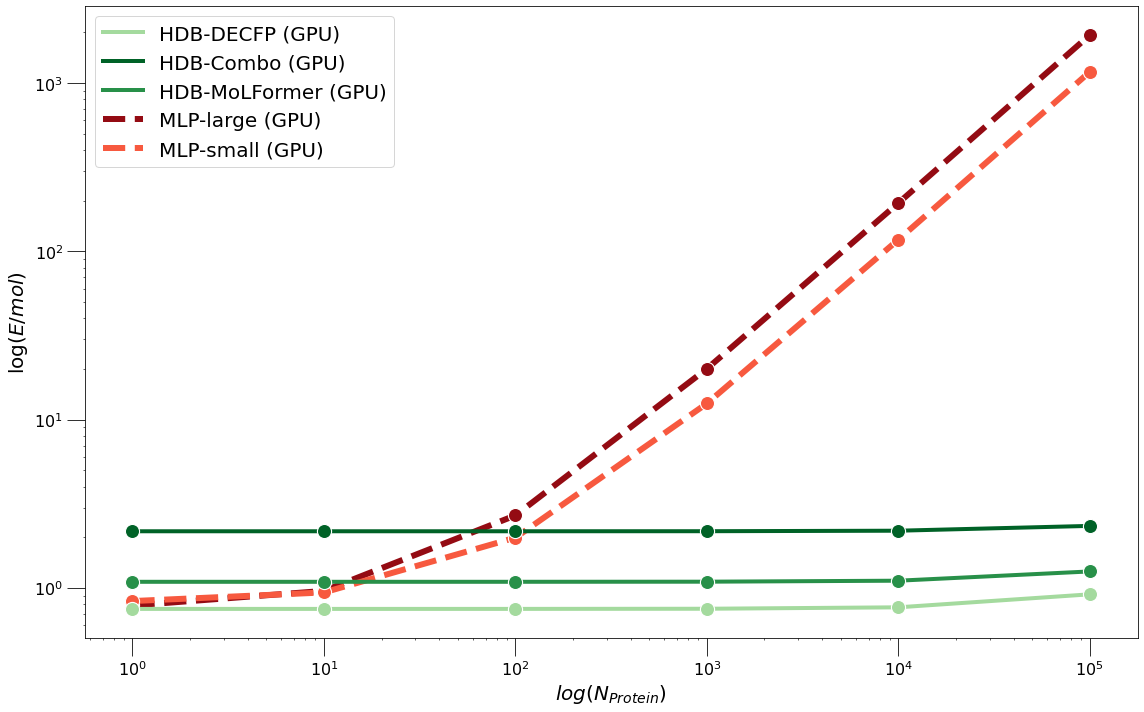

In [14]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
red_color_pal = sns.color_palette("Reds", 10)
purple_color_pal = sns.color_palette("Purples", 10)
rocket_color_pal = sns.color_palette("rocket", 10)


# plot_dict = {
            # "mlp-small-1024-1": ("MLP-small", red_color_pal[5]),
            # "mlp-large-1024-1": ("MLP-large", red_color_pal[9]),
            # "hdbind-molformer-decfp-combo-1k": ("HDB-Combo", green_color_pal[9]),
            # "hdbind-directecfp-1k-1": ("HDB-DECFP", green_color_pal[3]),
            # "hdbind-rp-molformer-1k": ("HDB-MoLFormer", green_color_pal[7])
    # }
plot_dict = {
            "mlp-small-1024-1": ("MLP-small", red_color_pal[5]),
            "mlp-large-1024-1": ("MLP-large", red_color_pal[9]),
            "hdbind-molformer-decfp-combo-1k-openhd": ("HDB-Combo", green_color_pal[9]),
            "hdbind-directecfp-1k-1-openhd": ("HDB-DECFP", green_color_pal[3]),
            "hdbind-rp-molformer-1k-openhd": ("HDB-MoLFormer", green_color_pal[7])
    }



def main(df):

    f, ax = plt.subplots(1,1, figsize=(16,10))


    zorder = 1
    for idx, ((model, device), model_df) in enumerate(df.groupby(["Model", "Device"])):

        if model in plot_dict.keys():
            x = [int(x) for x in col_list]
            y = model_df[col_list].values.reshape(-1)
            
            color = plot_dict[model][1]

            model_title = f"{plot_dict[model][0]} ({device})"

            print(model_title)


            linestyle = "-"
            label=model_title
            linewidth=4
            s=200
            if "mlp" not in model.lower():
                zorder = idx

                if device == "FPGA":
                    linestyle = "-."
            else:
                linewidth = 6
                zorder = 0
                linestyle = "--"


            sns.lineplot(x=x, y=y, label=label, ax=ax, markers="x", color=color, linestyle=linestyle, linewidth=linewidth,
                                zorder=zorder)
            sns.scatterplot(x=x, y=y, ax=ax, color=color, s=s, zorder=zorder)


    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel("$\log(E/{mol})$")
    ax.set_xlabel("$log$($N_{Protein})$")

    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)

    plt.tight_layout()
    plt.savefig("hdbind_energy.png", dpi=450)
main(screen_df)

In [ ]:
encode_col_str = 'Encode (J/mol)'
test_col_str = 'Test (J/mol)'
screen_df[encode_col_str] = screen_df[encode_col_str].astype(float)
screen_df[test_col_str] = screen_df[test_col_str].astype(float)

round_df = screen_df.round({encode_col_str: 3, test_col_str: 6, '1': 3, '10': 3, '100': 3, '1000': 3, '10000': 3, '100000': 3})
mlp_large_test_energy = round_df[round_df["Model"] == "mlp-large-1024-1"][test_col_str]
mlp_small_test_energy = round_df[round_df["Model"] == "mlp-small-1024-1"][test_col_str]
round_df["mlp-large_test_improvement"] = round_df.apply(lambda x:  mlp_large_test_energy / x[test_col_str], axis=1)
round_df["mlp-small_test_improvement"] = round_df.apply(lambda x:  mlp_small_test_energy / x[test_col_str], axis=1)
round_df
round_df[round_df["Model"] == "mlp-large-1024-1"]["Test (J/mol)"]
print(round_df)
print(round_df['Encode (J/mol)'])
round_df.to_latex("hdbind_latex_energy_costs.tex", index=False)

In [ ]:
round_df